In [40]:
%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (20.0, 10.0)
seaborn.mpl.rcParams['savefig.dpi'] = 180
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import coint as st_coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

import statsmodels.api as sm
from scipy.optimize import basinhopping
from scipy.stats import norm

import cPickle as cp
from math import sqrt

研究pair trading交易策略：  
方向：  
1、文献法1：  
$$R_i = \beta_0 + \beta_1 r_i + \sigma dX_t$$
2、使用协整关系建立模型(VEC)  
    problem: 由于正态性不满足，Granger两部法的协整检验无效
    solution: Johanson检验是否可行？
3、使用差分后的平稳序列  
4、使用VAR模型  

In [42]:
# data reading
df = pd.read_csv("./Data/close.csv", dtype={"date": str})

In [3]:
# some consts defined here

hs_class = [
    "SRB", "SHC", "DXI", "DXJ", "DJM"
]

yz_class = [
    "DXM", "DXY", "DXP", "ZOI"
]

gjs_class = [
    "SAU", "SAG"
]

bond_class = [
    "FXT", "FTF"
]

stock_class = [
    "FIF", "FIC", "FIH"
]

price_class = [
    "open", "high", "close", "low", "settle"
]

#COINT_TYPE = ["c", "ct", "ctt", "nc"]
COINT_TYPE = ["c"]

functions below

In [4]:
def get_coint_ar(price_ar, coint_period, coint_type):
    tmp_ar = np.ones((len(price_ar), 1)) * np.nan
    
    for idx in xrange(len(price_ar)):
        if idx < coint_period:
            continue
        
        _, pvalue, _ = st_coint(
            price_ar[idx - coint_period : idx, 0], 
            price_ar[idx - coint_period : idx, 1],
            coint_type,
        )
            
        tmp_ar[idx] = pvalue
    return tmp_ar

def get_stationary_ar(price_ar, station_period, regression):
    tmp_ar = np.ones((len(price_ar), 1)) * np.nan
    
    for idx in xrange(len(price_ar)):
        if idx < station_period:
            continue
        pvalue = adfuller(
            price_ar[idx - station_period: idx], 
            regression=regression,
        )[1]
            
        tmp_ar[idx] = pvalue
    return tmp_ar

def get_regression_ar(price_ar, regression_period):
    tmp_ar = np.ones((len(price_ar), 1)) * np.nan
    
    y = df2["FTF"].values
    x = sm.add_constant(df2["FXT"].values)
    model = sm.OLS(y, x)
    result = model.fit()
    print result.summary()
    
    for idx in xrange(len(price_ar)):
        if idx < station_period:
            continue
        pvalue = adfuller(
            price_ar[idx - station_period: idx], 
            regression=regression,
        )[1]
            
        tmp_ar[idx] = pvalue
    return tmp_ar

In [5]:
def plot_coint_p_value(ticker1, ticker2, coint_period, coint_type, save_fig=False):
    df2 = df.loc[:, [ticker1, ticker2]].dropna()

    coint_ar = get_coint_ar(df.loc[:, [ticker1, ticker2]].values, coint_period, coint_type)

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    ax1.plot(df2[ticker1], 'r', label=ticker1)
    ax1.plot(df2[ticker2], 'b', label=ticker2)
    plt.legend(loc="upper left")
    ax2 = ax1.twinx()
    
    pic_name = "coint_{}&{}_{}_{}".format(ticker1, ticker2, coint_period, coint_type)
    ax2.plot(coint_ar, 'g', label=pic_name)
    plt.legend(loc="upper right")
    
    if save_fig:
        fig.savefig("./Pics/{}.png".format(pic_name))
    
    return fig

def plot_station_p_value(ticker_se, ticker, station_period, regression, save_fig=False):    
    stationary_ar = get_stationary_ar(ticker_se.values, station_period, regression)
    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(111)
    ax1.plot(ticker_se.values, 'r', label=ticker)
    plt.legend(loc="upper left")
    ax2 = ax1.twinx()
    
    pic_name = "stationay_{}_{}_{}".format(ticker, station_period, regression)
    ax2.plot(stationary_ar, 'g', label=pic_name)
    plt.legend(loc="upper right")
    
    if save_fig:
        fig.savefig("./Pics/{}.png".format(pic_name))
    
    return fig

In [10]:
"""
class SignalGenerator(object):
    
    def __init__(self, s_score, buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p):
        self.buy_open = s_score.quantile(buy_open_p)
        self.buy_close = s_score.quantile(buy_close_p)
        self.sell_open = s_score.quantile(sell_open_p)
        self.sell_close = s_score.quantile(sell_close_p)
        self.buy_stop = s_score.quantile(buy_stop_p)
        self.sell_stop = s_score.quantile(sell_stop_p)
    
    def test(self):
        i = 1
        last_position = 0
        while i < len():
            if s_score[i] < self.sell_open and self.s_score[i - 1] >= sell_open: # sell open
                position = -1
            elif s_score[i] < self.sell_close and self.s_score[i - 1] >= sell_close: # sell close
                position = 0
            elif s_score[i] > self.buy_open and self.s_score[i - 1] <= buy_open: # buy open
                position = 1
            elif s_score[i] > self.buy_close and s_score[i - 1] <= buy_close: # buy close
                position = 0
            elif (s_score[i] < self.buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
                position = 0
            else: # do nothing
                position = last_position
            yield position
            i += 1
            last_position = position
"""

def back_test_r(args): # at this version their is no stop loss
    s_score, resid_se, buy_open_p, buy_close_p, sell_close_p, sell_open_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
        
    signal_ar = np.zeros((len(resid_se), 1))
    
    for i in range(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        else: # do nothingjjjjj
            signal_ar[i] = signal_ar[i - 1]
    
    return ((resid_se[2:].values * signal_ar[:-2].T).cumsum()[-1], buy_open_p, buy_close_p, sell_close_p, sell_open_p)

def back_test_sharp(args): # at this version their is no stop loss
    s_score, resid_se, buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
    buy_stop = s_score.quantile(buy_stop_p)
    sell_stop = s_score.quantile(sell_stop_p)
        
    signal_ar = np.zeros((len(resid_se), 1))
    
    for i in xrange(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        elif (s_score[i] < buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
            signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
    
    return_rate = (resid_se[2:].values * signal_ar[:-2].T).cumsum()
    return (return_rate[-1] / return_rate.std(), buy_stop, buy_open, buy_close, sell_stop, sell_open, sell_close)

def back_test(args): # at this version their is no stop loss
    s_score, resid_se, buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p = args
    buy_open = s_score.quantile(buy_open_p)
    buy_close = s_score.quantile(buy_close_p)
    sell_open = s_score.quantile(sell_open_p)
    sell_close = s_score.quantile(sell_close_p)
    buy_stop = s_score.quantile(buy_stop_p)
    sell_stop = s_score.quantile(sell_stop_p)
        
    signal_ar = np.zeros((len(resid_se), 1))

    
    for i in xrange(1, len(resid_se)):
        if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
            signal_ar[i] = -1
        elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
            signal_ar[i] = 0
        elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
            signal_ar[i] = 1
        elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
            signal_ar[i] = 0
        elif (s_score[i] < buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
            signal_ar[i] = 0
        else: # do nothing
            signal_ar[i] = signal_ar[i - 1]
    
    return ((resid_se[2:].values * signal_ar[:-2].T).cumsum(), buy_stop_p, buy_open_p, buy_close_p, sell_stop_p, sell_open_p, sell_close_p)

def generate_position(resid, last_sscore, volatility, buy_stop, buy_open, buy_close, sell_stop, sell_opens, sell_close): # we need at least two entries in s_score
    sscore = resid / volatility
    if s_score[i] < sell_open and s_score[i - 1] >= sell_open: # sell open
        signal_ar[i] = -1
    elif s_score[i] < sell_close and s_score[i - 1] >= sell_close: # sell close
        signal_ar[i] = 0
    elif s_score[i] > buy_open and s_score[i - 1] <= buy_open: # buy open
        signal_ar[i] = 1
    elif s_score[i] > buy_close and s_score[i - 1] <= buy_close: # buy close
        signal_ar[i] = 0
    elif (s_score[i] < buy_stop and s_score[i - 1] >= buy_stop) or (s_score[i] > sell_stop and s_score[i - 1] <= sell_stop):
        signal_ar[i] = 0
    else: # do nothing
        signal_ar[i] = signal_ar[i - 1]
    return signal

end of functions

method 2, according to the essay:  
and we assume the $X_t$ is a white noise


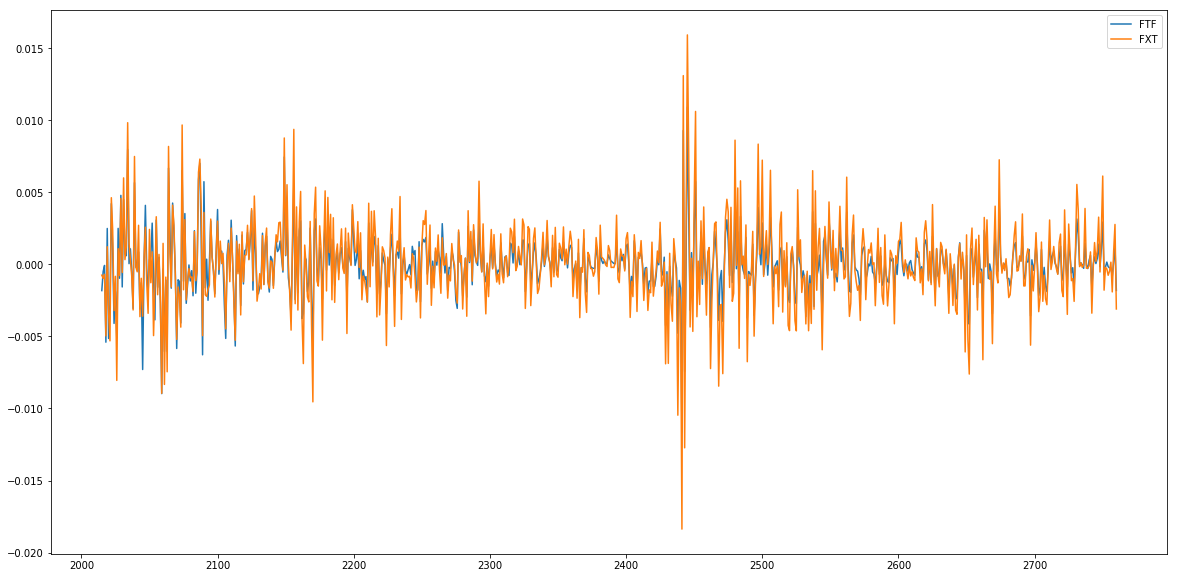

In [43]:
# get return rate data
df2 = np.log(df.loc[:, ["FTF", "FXT"]]).diff().dropna()
df2.plot(figsize=(20, 10))

In [44]:
# estimate beta0 and beta1
A = df2["FTF"].values
y = df2["FXT"].values
A = np.vstack((np.ones_like(A), A)).T

x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)
resid = y - A.dot(x)

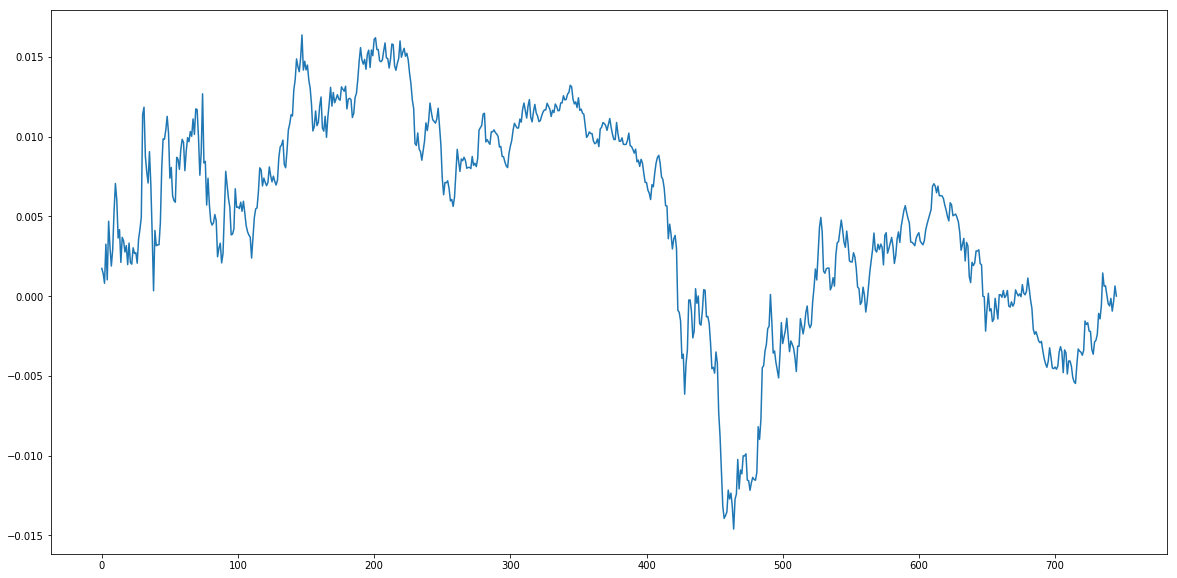

In [58]:
plt.plot(resid.cumsum())

In [46]:
resid_se = pd.Series(resid)

# there are two ways of calculating std
# way2
std2_se = resid_se.rolling(
    window=100,
).apply(lambda x: sqrt(sum(np.diff(x)**2) / (len(x) - 1)))

# calculate alpha
alpha_se = resid_se.rolling(
    window=100
).apply(lambda x: -sum(np.diff(x) * x[:-1]) / sum(x[:-1]**2))

mean_se = resid_se.rolling(
    window=100,
).mean()

可以看到残差方差随时间变化，不是一个平稳过程，接下来先假设方差在长期内为一个固定的常数，残差平稳，进行研究

(4.2307733252178235, 0.15, 0.16, 0.17, 0.85, 0.79, 0.73)


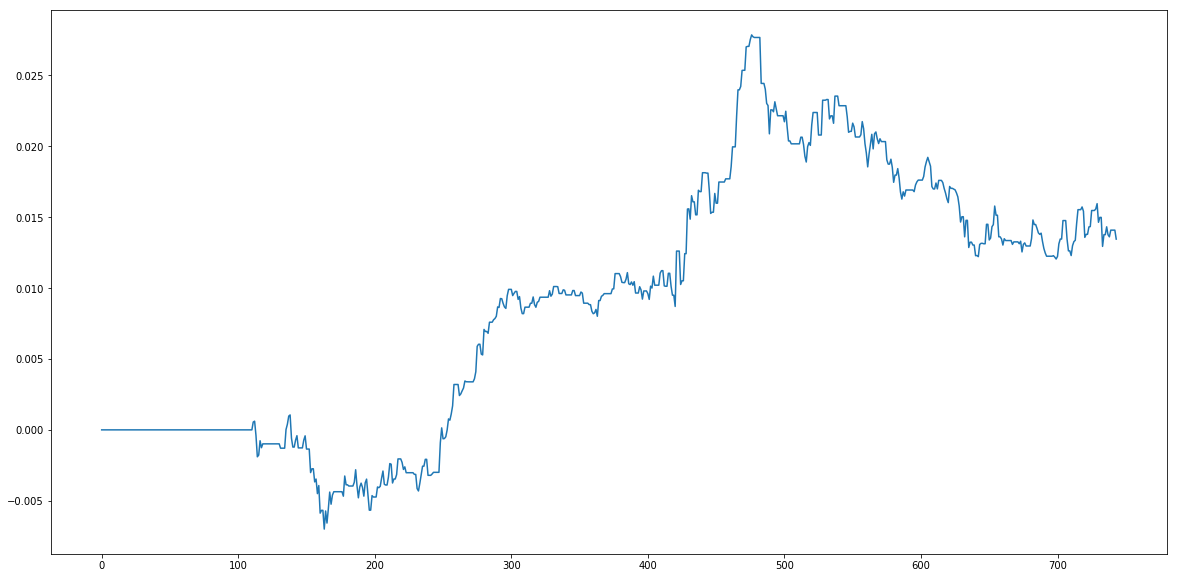

In [60]:
# the best result can achieve using std2_se, optimize return rate
with open("./pkl/EG_result_lst_FXT_FTF_sharp", "r") as fp:
    result_lst = cp.load(fp)
result_lst.sort(key=lambda x: x[0], reverse=True)
s_score = (resid_se - mean_se) / std2_se
print result_lst[0]
args = result_lst[0][1:]
res = back_test((s_score, resid_se, args[0], args[1], args[2], args[3], args[4], args[5]))
res = back_test((s_score, resid_se, 0.1, 0.2, 0.3, 0.9, 0.8, 0.7))
fig = plt.figure(figsize=(20, 10))
plt.plot(res[0])

In [16]:
def test_and_print(ticker1, ticker2):
    df2 = np.log(df.loc[:, [ticker1, ticker2]]).diff().dropna()

    # estimate beta0 and beta1
    A = df2[ticker1].values
    y = df2[ticker2].values
    A = np.vstack((np.ones_like(A), A)).T

    x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)
    resid = y - A.dot(x)

    resid_se = pd.Series(resid)

    # there are two ways of calculating std
    # way2
    std2_se = resid_se.rolling(
        window=100,
    ).apply(lambda x: sqrt(sum(np.diff(x)**2) / (len(x) - 1)))

    # calculate alpha
    mean_se = resid_se.rolling(
        window=100,
    ).mean()
    res = back_test((s_score, resid_se, 0.15, 0.16, 0.30, 0.85, 0.84, 0.70))
    fig = plt.figure(figsize=(20, 10))
    plt.plot(res[0], label="{}_{}".format(ticker1, ticker2))
    plt.legend()

At this block, we try to fit a GARCH model to predict volatility
for utilities, we need a data pool, a back testing function

In [17]:
def array_shift(ar, n):
    ar2 = ar.copy()
    if n == 0:
        return ar2
    ar2[n : ] = ar2[: -n]
    ar2[ : n] = 0
    return ar2

In [18]:
# first we need to construct a model GARCH(m, n, o, p, q)
r1 = df2["SHC"].values.T
r2 = df2["DXI"].values.T
a = 0
b = 0
t = 0
g = 1
r = 1

In [19]:
alpha = np.random.rand(a + 1, 1)
beta = np.random.rand(b, 1)
theta = np.random.rand(t + 1, 1)
gamma = np.random.rand(g + 1, 1)
rho = np.random.rand(r, 1)

r1_lag = np.vstack((np.ones_like(r1), reduce(lambda x, y: np.vstack((x, y)), [r1] + [array_shift(r1, i) for i in range(1, a)]))).T
r2_lag = reduce(lambda x, y: np.vstack((x, y)), [r2] + [array_shift(r2, i) for i in range(0, t)]).T

at = np.ones((len(r1), 1))
sigma_squre = np.ones((len(r1), 1))
at[0 : max(b, r)] = np.random.rand(max(b, r), 1)
sigma_squre[0 : g] = np.random.rand(g, 1)


def calc_likelihood(alpha, beta, theta, gamma, rho):
    for i in xrange(len(r1)):
        if i < r or i < b or i < g:
            continue
        sigma_squre[i] = min(np.vstack((np.array([1]), sigma_squre[i-g:i])).T.dot(gamma) + (at[i-r:i]**2).dot(rho), 1e-5)
        at[i] = r1[i] - r1_lag[i, :].dot(alpha) - at[i-b : i].dot(beta) - r2_lag[i, :].dot(theta)
    return sum(np.log(norm.pdf(at / sigma_squre)))

In [20]:
def target_func(x):
    alpha = x[0 : a + 1]
    beta = x[a + 1 : a + 1 + b]
    theta = x[a + 1 + b : a + 1 + b + t + 1]
    gamma = x[a + 1 + b + t + 1 : a + 1 + b + t + 1 + g + 1]
    rho = x[a + 1 + b + t + 1 + g + 1 : a + 1 + b + t + 1 + g + 1 + r]
    return calc_likelihood(alpha, beta, theta, gamma, rho)

In [21]:
init_x = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

use package "arch" to broadly test volatility modeling, attain std adjusted residues.

In [48]:
from arch.univariate import *

Iteration:      1,   Func. Count:      7,   Neg. LLF: -4151.84721846
Iteration:      2,   Func. Count:     23,   Neg. LLF: -4151.99803009
Iteration:      3,   Func. Count:     39,   Neg. LLF: -4152.05214953
Iteration:      4,   Func. Count:     56,   Neg. LLF: -3195.24524269
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3195.24523669
            Iterations: 5
            Function evaluations: 56
            Gradient evaluations: 4


E:\Anaconda2\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


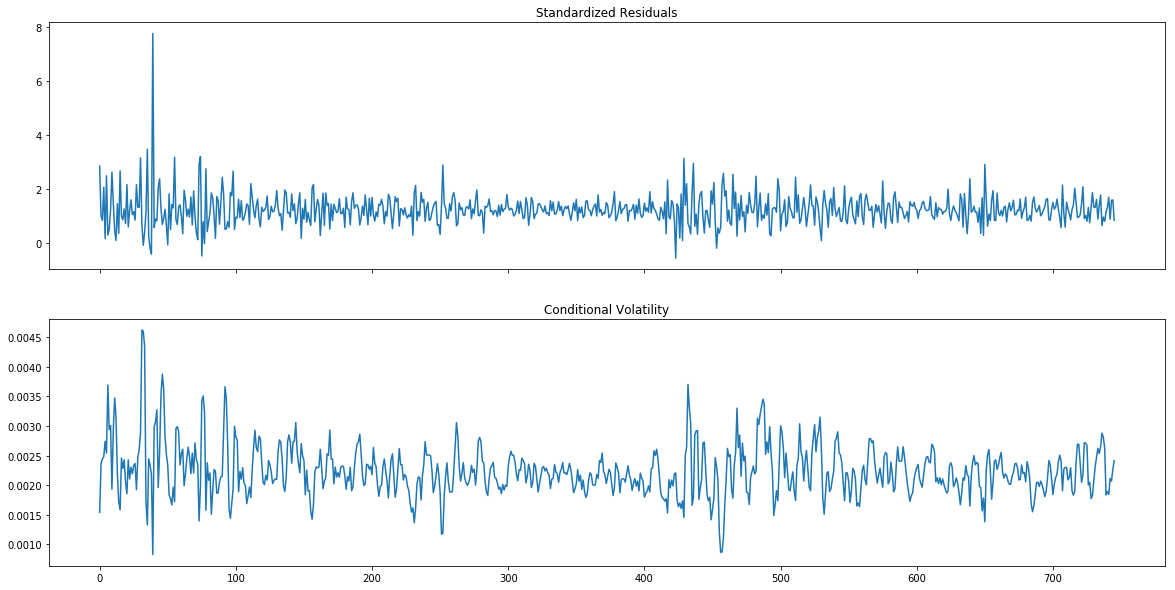

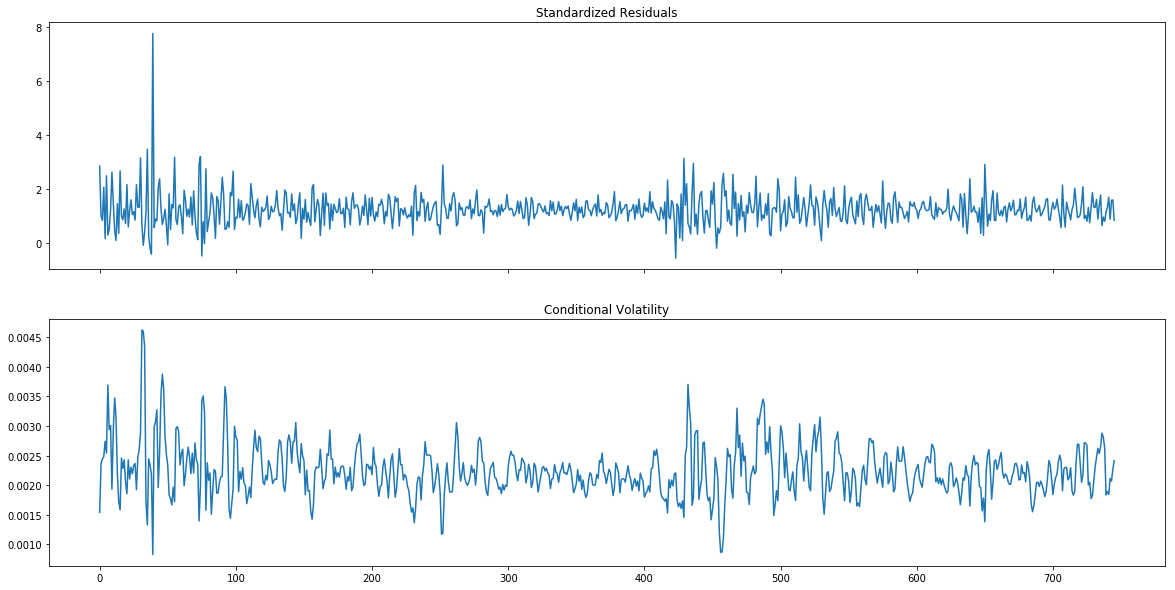

In [49]:
ar = ARX(resid_se, volatility=ARCH(3)).fit()
ar.plot()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -4190.5480465
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4190.54804609
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


E:\Anaconda2\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


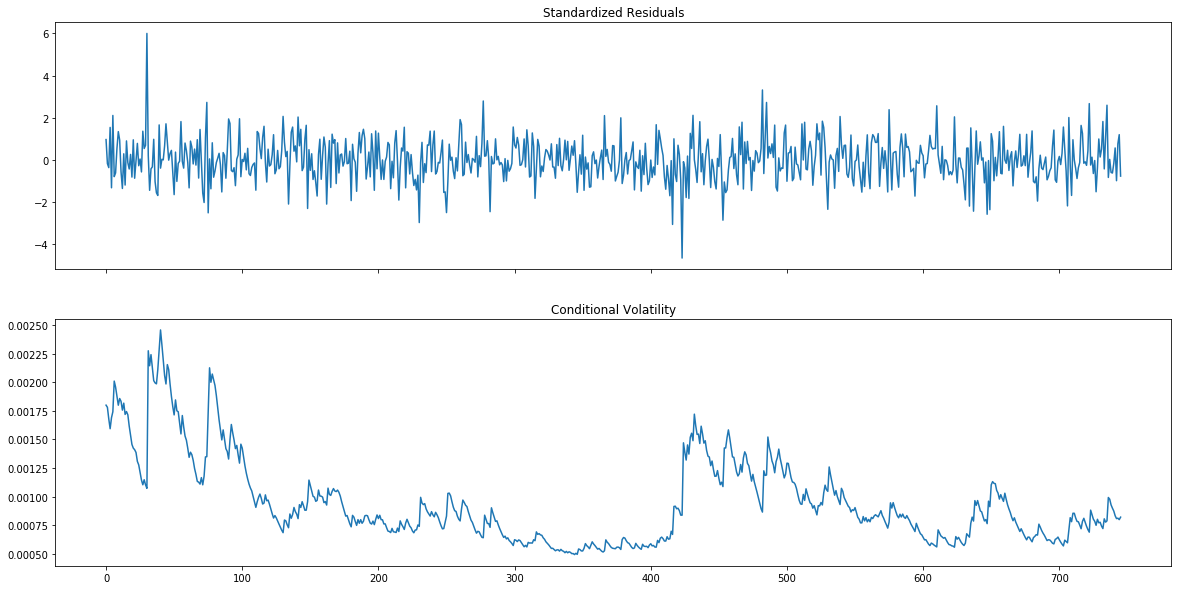

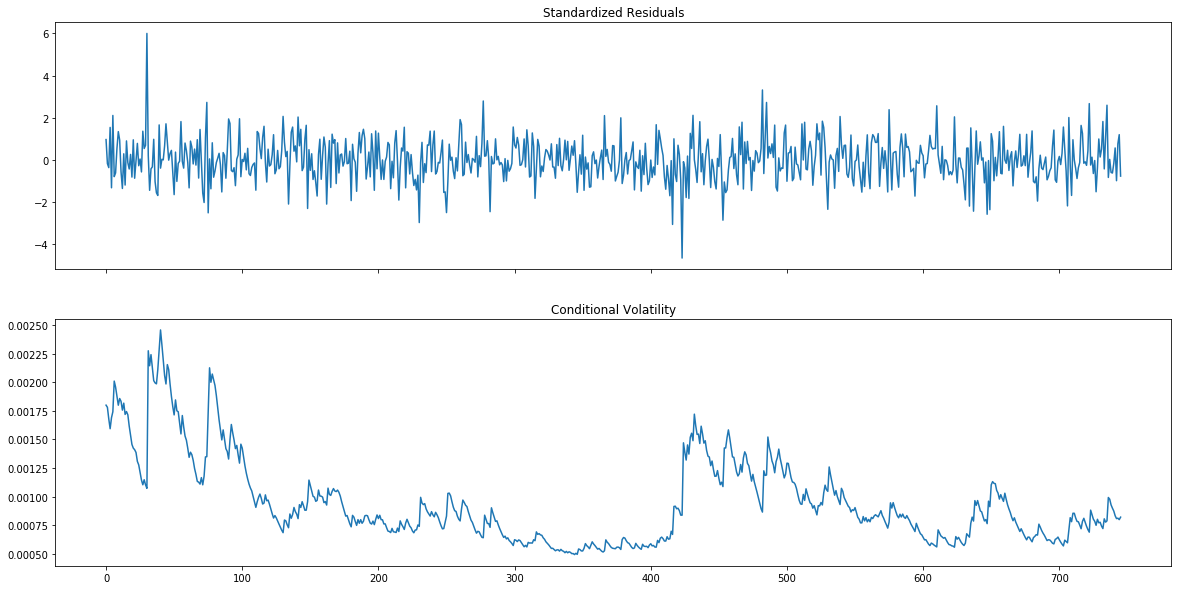

In [50]:
ar = ARX(resid_se, volatility=GARCH(1, 0, 1))
res = ar.fit()
res.plot()

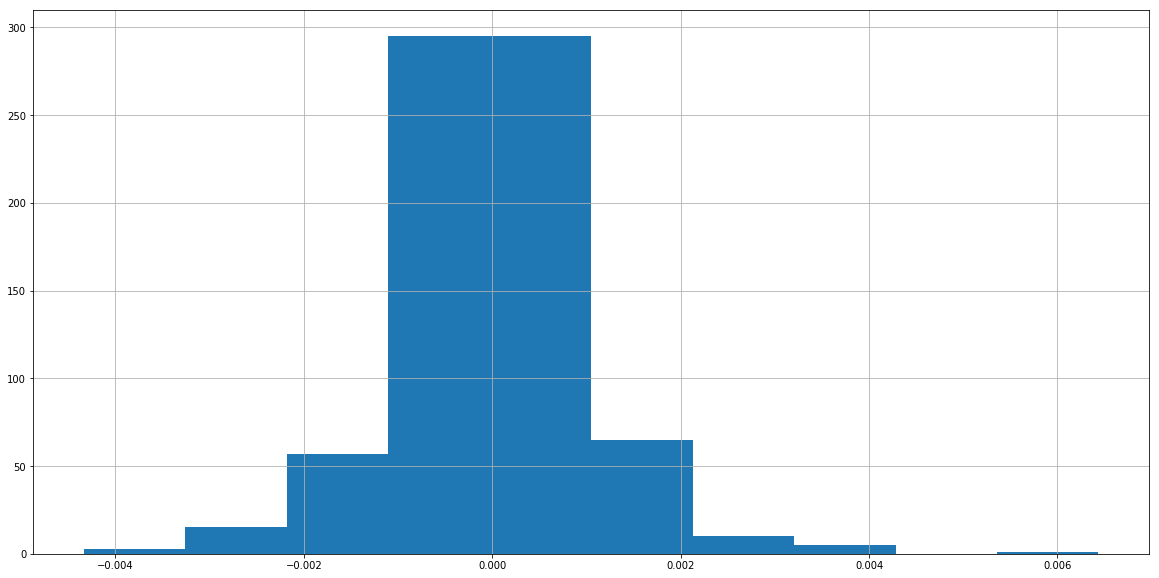

In [51]:
res.resid.hist()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -4206.3827932
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4206.3827932
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1


E:\Anaconda2\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


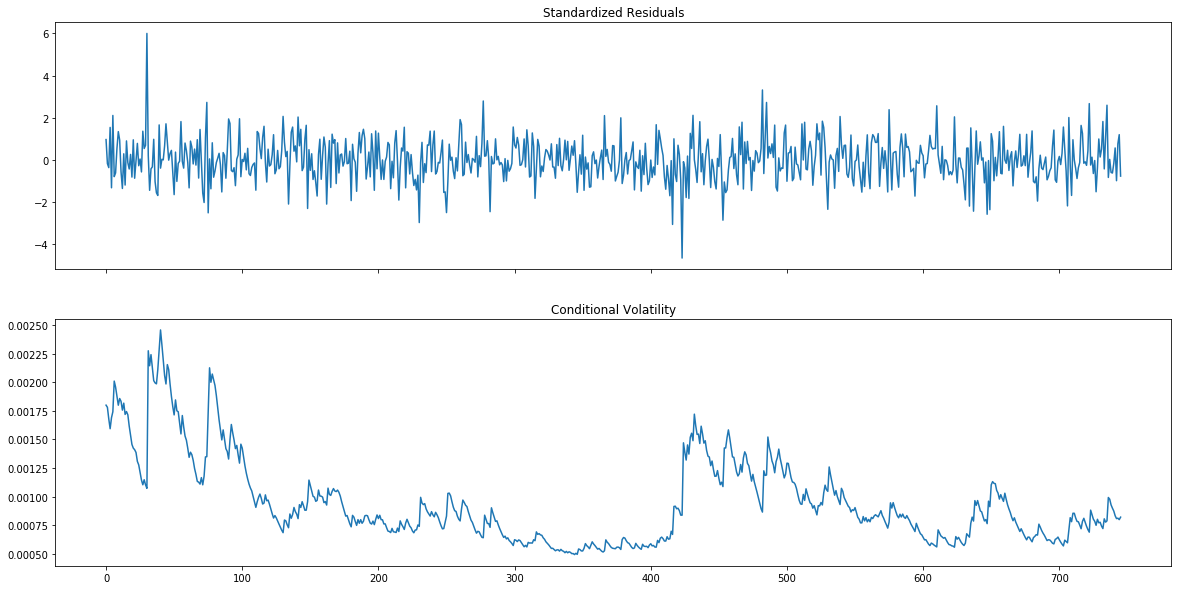

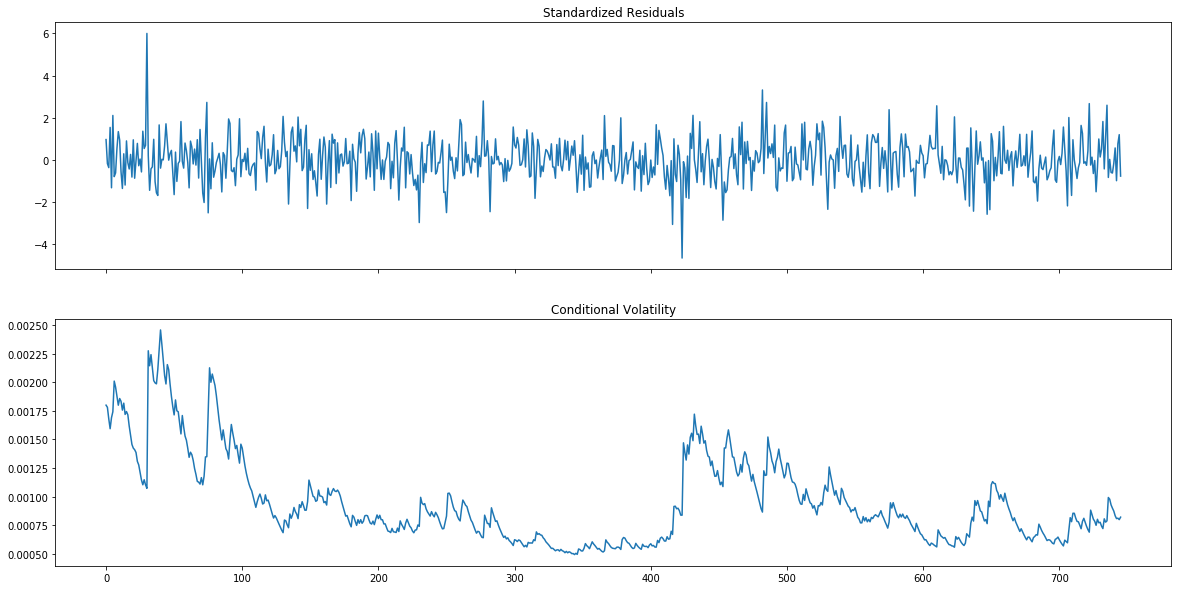

In [63]:
ar = ARX(resid_se, volatility=GARCH(1, 0, 1))
ar.distribution=StudentsT()
res = ar.fit()
res.plot()

Iteration:      1,   Func. Count:      8,   Neg. LLF: -4206.3827935
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4206.3827932
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1


E:\Anaconda2\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


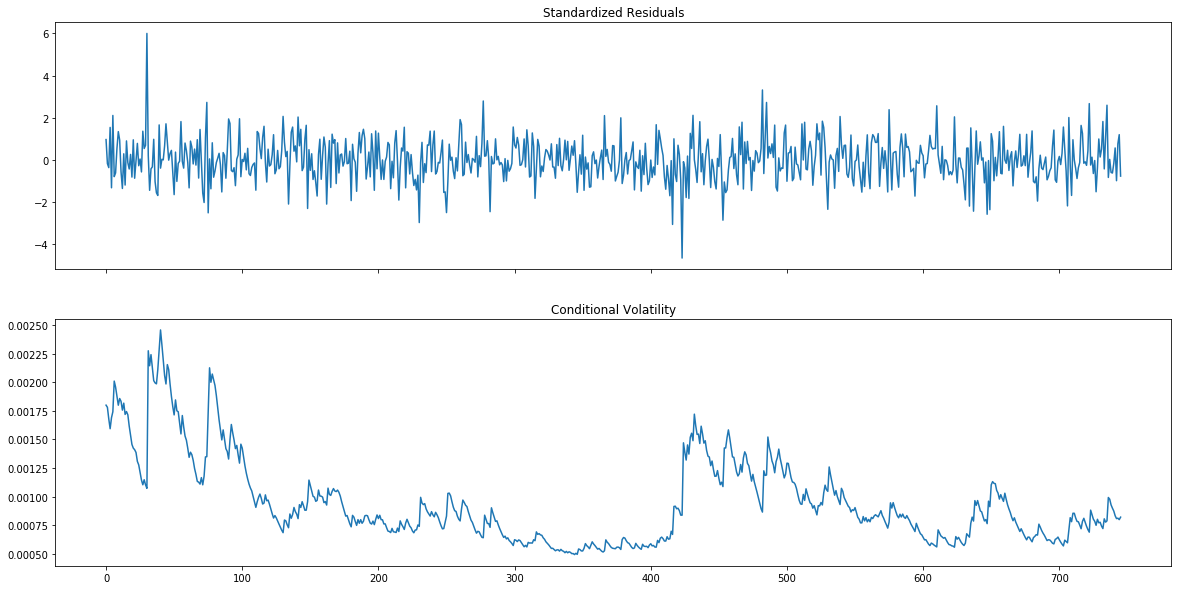

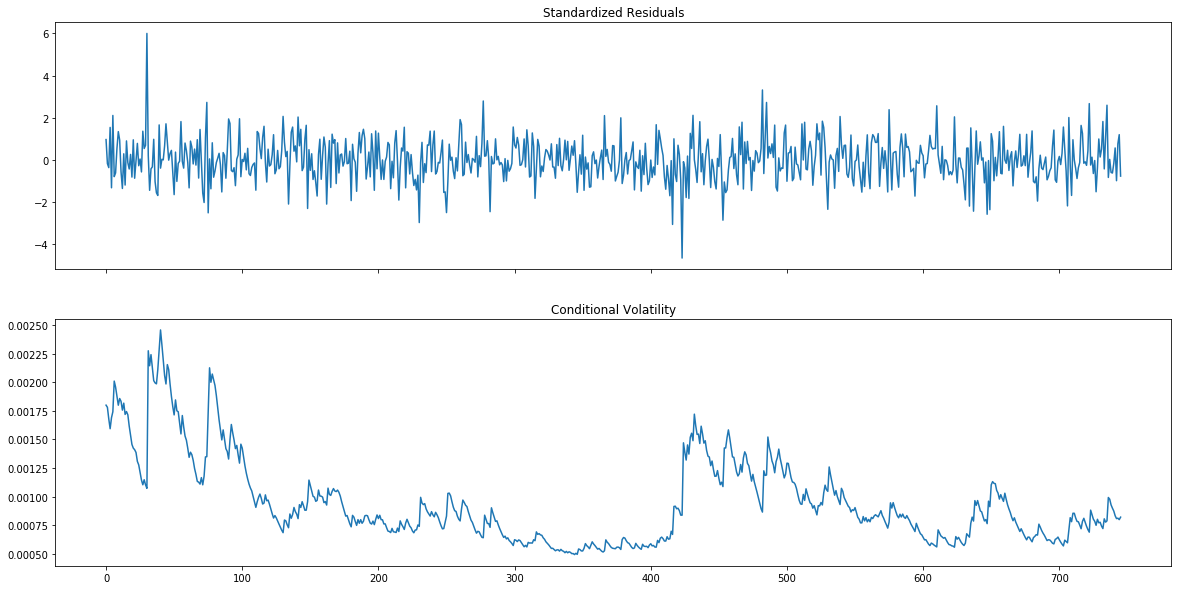

In [67]:
ar = ARX(resid_se, volatility=GARCH(1, 0, 1))
ar.distribution=SkewStudent()
res = ar.fit()
res.plot()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1895376.83325
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1643252.85706
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


E:\Anaconda2\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


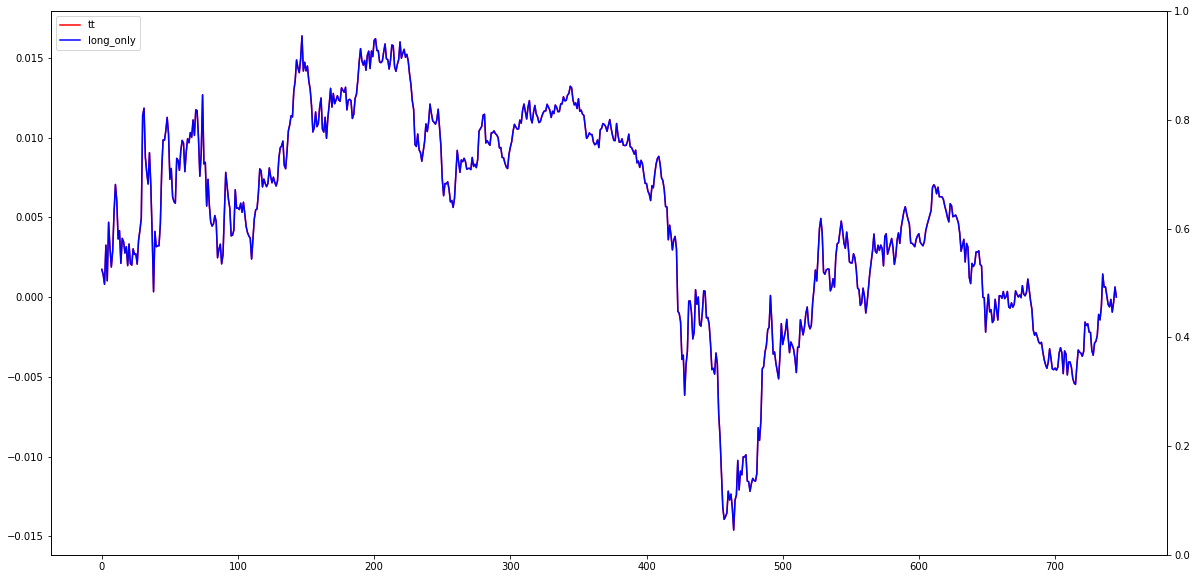

In [54]:
ar = ARX(resid_se, volatility=EGARCH(1, 0, 1))
res = ar.fit()
#res.plot()
tt = res.resid.cumsum()

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax1.plot(tt, 'r', label="tt")
ax1.plot(resid_se.cumsum(), 'b', label="long_only")
plt.legend(loc="upper left")
ax2 = ax1.twinx()

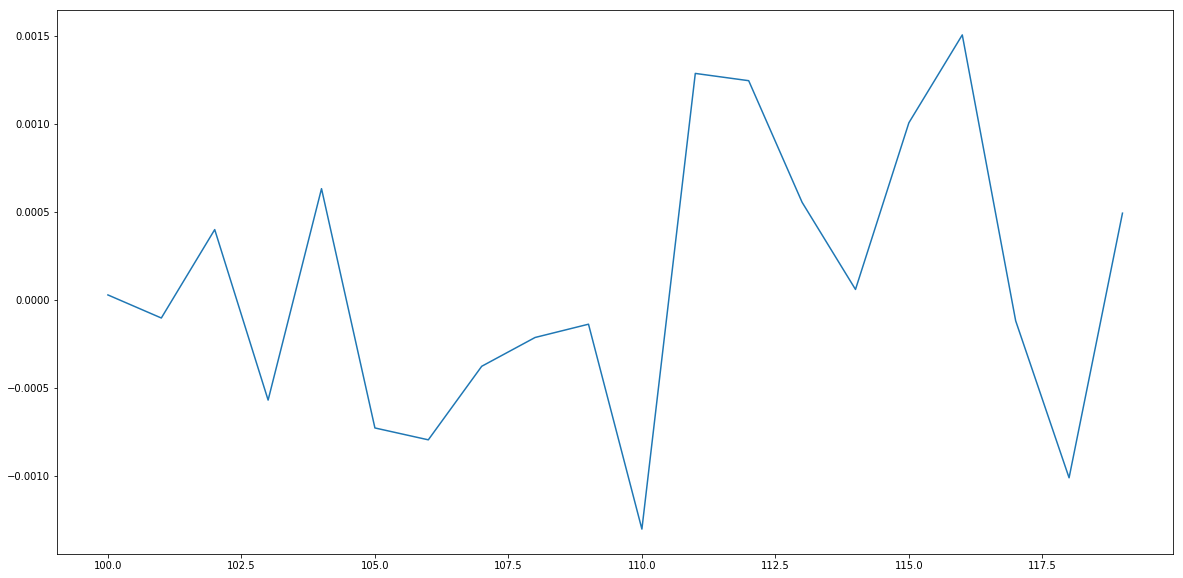

In [55]:
fig = plt.figure(figsize=(20, 10))
plt.plot(res.resid[100 : 120])

问题是交易频率太高，一单可能拿一两天

$$\sigma^{2}=\omega + \sum_{i=1}^{m}\alpha_{l_{i}}\left(l_{i}^{-1}\sum_{j=1}^{l_{i}}\epsilon_{t-j}^{2}\right)$$

$$\sigma_{t}^{2}=\omega+\alpha_{1}\epsilon_{t-1}^{2}
    +\alpha_{5} \left(\frac{1}{5}\sum_{j=1}^{5}\epsilon_{t-j}^{2}\right)
    +\alpha_{22} \left(\frac{1}{22}\sum_{j=1}^{22}\epsilon_{t-j}^{2}\right)$$


def on_tick(idx, retrain_period， mean_model=ARX, volatility_model=EGARCH(2, 0, 2), dist=SkewStudent()):
    # df = pd.read_csv("./Data/close.csv", dtype={"date": str})

    # df2 = np.log(df.loc[:, [ticker1, ticker2]]).diff().dropna()
    # x = df2[ticker1].values
    # y = df2[ticker2].values
    A = np.vstack((np.ones_like(x), x)).T

    b = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(y)
    resid = y - A.dot(b)

    resid_se = pd.Series(resid)
    
    ar = mean_model(resid_se, volatility=volatility_model)
    ar.distribution = dist
    res = ar.fit()
    s_score = pd.Series(resid)

    arg_lst = [
        (s_score, resid_se, i / 100.0, j / 100.0, k / 100.0, l / 100.0, m / 100.0, n / 100.0) for i in xrange(15, 35, 5) for j in xrange(i + 1, 49, 5) for k in xrange(j + 1, 50, 5) for l in xrange(85, 65, -5) for m in xrange(l - 1, 51, -5) for n in xrange(m - 1, 50, -5)
    ]

    pool = mp.Pool(6)
    result = pool.map(back_test_sharp, arg_lst)
    pool.close()
    pool.join()

    result.sort(key=lambda x: x[0], reverse=True)
    best = result[0]
    return 

In [68]:
# to do:
# 1. finish the estimator process.
# 2. is it true that the z_score is too fast to trade?
s_score = res.resid
result = back_test((s_score, resid_se, 0.1, 0.2, 0.3, 0.9, 0.8, 0.7))[0]

In [71]:
result

array([-0.00000000e+00, -2.45297458e-03, -2.15398579e-04, -2.15398579e-04,
        1.38177560e-03,  1.72907264e-04, -8.49655952e-04, -3.26153168e-03,
       -1.52028043e-03, -1.52028043e-03, -1.52028043e-03, -2.04435587e-03,
       -2.04435587e-03, -4.74773572e-04, -4.74773572e-04, -1.17351325e-03,
       -1.57161246e-03, -3.82729373e-04,  9.71881251e-04,  9.71881251e-04,
        8.76744483e-04, -1.46122372e-04, -5.01012476e-04, -4.53081399e-04,
        2.01932680e-04, -1.29933690e-03, -1.91858351e-03, -1.15300912e-03,
       -7.58792558e-03, -8.04750382e-03, -8.04750382e-03, -7.09265010e-03,
       -7.09265010e-03, -7.09265010e-03, -7.09265010e-03, -1.01944040e-02,
       -6.63154044e-03, -1.04156849e-02, -9.45367228e-03, -9.38859100e-03,
       -9.38653822e-03, -8.01326363e-03, -4.61854741e-03, -4.61854741e-03,
       -4.61854741e-03, -4.61854741e-03, -5.46427536e-03, -4.40788487e-03,
       -1.58366280e-03, -2.26368278e-03, -2.26368278e-03, -2.55498179e-03,
       -2.45114365e-03,  

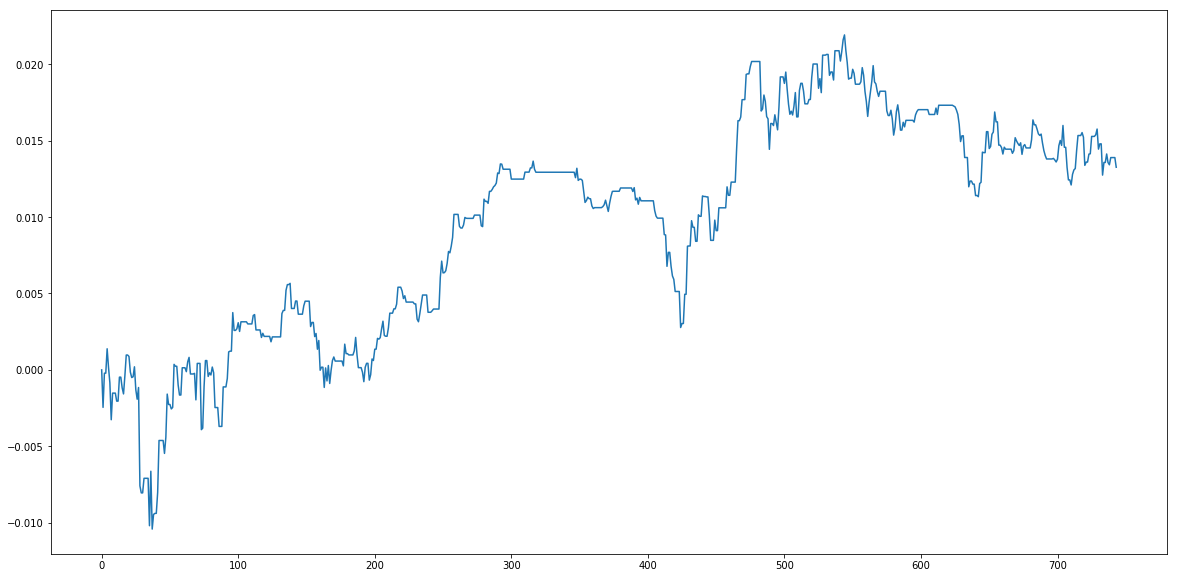

In [72]:
plt.plot(result)